In [1]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wGK67izN6piqtoHi4ctFbrz0qvMAeX3pK2pGF66UzJkPHUDfQd7Hnc
Mounted at /content/drive


# 05 Bayesian Linear Regression for Student Grade Prediction

In this notebook, we will develop bayesian linear regression for student grade prediction.  We will conduct EDA to analyze data, develop conventional linear regresion, implement Bayesian Linear Regression using [PyMC3](https://docs.pymc.io/) and interpret the results. What is more, we will show the posterior predictive of a data sample generated by bayesian models could be used as a trigger measure to detect anomaly data (fraud case). It consists of two parts: **Exploratory Data Analysis** (EDA) and **Modeling** parts. 

This is the second part for modeling. 

The agenda is as follow:

1. Develop linear regression for student grade prediction 
2. Develop bayesian linear regressopm for student grade prediction

### Import Libraries

In [2]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(123)
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['figure.figsize'] = (5, 5)
import seaborn as sns
from IPython.core.pylabtools import figsize
# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load the data


In [3]:
datafolder = "/content/drive/My Drive/fraud_analysis/datasets/"
file_name = "student-mat.csv"
df_data = pd.read_csv(datafolder + file_name, sep=';', index_col=None)

In [4]:
df_data.rename(columns={'G3': 'Grade'}, inplace=True)
df_data = df_data[~df_data['Grade'].isin([0, 1])]
df_data.head(2).append(df_data.tail(2))

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
393,MS,M,18,R,LE3,T,3,2,services,other,course,mother,3,1,0,no,no,no,no,no,yes,yes,no,4,4,1,3,4,5,0,11,12,10
394,MS,M,19,U,LE3,T,1,1,other,at_home,course,father,1,1,0,no,no,no,no,yes,yes,yes,no,3,2,3,3,3,5,5,8,9,9


### Import Libraries

In [5]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error
# Distributions
import scipy

## Baseline and Linear Regression for Students Grade Prediction

In the following we are going to build machine learning model to predict the student grade. 

we will select several columns as features: 
1. failures

  number of past class failures 

  (numeric: n if 1<=n<3, else 4)

2. Medu

  mother's education

  (numeric: 0 - none, 1 - primary education (4th grade), 2 means 5th to 9th grade, 3 means secondary education or 4 is higher education) 

3. studytime

  weekly study time 

  (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours) 

4. absences

  number of school absences 

  (numeric: from 0 to 93) 


5. higher

  wants to take higher education 

  (binary: yes or no) 

Usually, we need to conduct [feature selections/extraction](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) to arrive at those features. 

The target value will be the Grade column.

In addition, since internet is the categorical features, we use one-hot encoding to convert it to numerical values


Import Libraries 

In [6]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
# Splitting data into training/testing
from sklearn.model_selection import train_test_split
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Distributions
import scipy

In [7]:
df_used = df_data[['failures', 'Medu', 'studytime', 'absences', 'higher', 'Grade']]
df_used = pd.get_dummies(df_used)

In [8]:
df_X = df_used[['failures', 'Medu', 'studytime', 'absences', 'higher_yes']] #store features
df_X.rename(columns={'Medu': 'mother_edu'}, inplace=True) #store values
df_y = df_used[['Grade']]


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
df_X.head(3)

,failures,mother_edu,studytime,absences,higher_yes
0,0,4,2,6,1
1,0,1,2,4,1
2,3,1,2,10,1


In [10]:
 # Split into training/testing sets with 25% split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, 
                                                    test_size = 0.25,
                                                    random_state=123)

### Use Linear Regression Model for predictions

Sklearn provides very friendly functions.

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Evaluation Metrics

For this regression task, we will use two standard metrics:

* Mean Absolute Error (MAE): Average of the absolute value of the difference between predictions and the true values
* Root Mean Squared Error (RMSE): The square root of the average of the squared differences between the predictions and the true values.

Create a naive Baseline

For a regression task, a simple naive baseline is to guess the median value on the training set for all testing cases. If our machine learning model cannot better this simple baseline, then perhaps we should try a different approach or features!

In [12]:
baseline = np.median(y_train)
baseline_mae = np.mean(abs(baseline - y_test))
baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
print('Baseline, MAE is %0.2f' %  baseline_mae)  
print('Baseline, RMSE is %0.2f' %  baseline_rmse)    

Baseline, MAE is 2.83
Baseline, RMSE is 3.51


In [13]:
# Metrics
predictions = lr.predict(X_test)
mae = np.mean(abs(predictions - y_test))
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print('Using Linear Regression, MAE is %0.2f' %  mae)  
print('Using Linear Regression, MAE is %0.2f' %  rmse)    

Using Linear Regression, MAE is 2.74
Using Linear Regression, MAE is 3.28


In [14]:
ols_formula = 'Grade = %0.2f +' % lr.intercept_
for i, col in enumerate(X_train.columns):
    ols_formula += ' %0.2f * %s +' % (lr.coef_[0][i], col)
    
print(' '.join(ols_formula.split(' ')[:-1]))

Grade = 9.15 + -0.71 * failures + 0.42 * mother_edu + 0.50 * studytime + -0.08 * absences + 0.88 * higher_yes


### Interpret model parameters

It is quite intuitive. For the features: failures and absences, their coefficients are negative. However, the model parameters and its correponding prediction value are fixed numbers. It fails to capture **uncertainity**. In the following, we will develop bayesian linear regression to address the above issue.

## Using Bayesian Linear Regression

We will create Bayesian Linear Regression in PyMC3. Markov Chain Monte Carlo algorithms will be used to draw samples from the posterior to approximate the the posterior for each of the model parameters. The version should be 3.8.



In [15]:
! pip install pymc3==3.8

     |████████████████████████████████| 911kB 6.6MB/s 
     |████████████████████████████████| 1.5MB 22.5MB/s 
     |████████████████████████████████| 4.3MB 46.8MB/s 
     |████████████████████████████████| 296kB 55.1MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [16]:
import pymc3 as pm

In [17]:
print(pm.__version__)

3.8


In [18]:
def model_build(df_train, df_label=None):
  """
  build genearlized linear model
  """
  with pm.Model() as model:
    sigma = pm.Uniform('sigma', 0, 10) #the error term is an uniform distribution
    num_fea = df_train.shape[1]
    mu_infe = pm.Normal('intercept', mu=0, sigma=10) #the bias term is an normal distribution (mean=0, sigma=10)
    for idx in range(num_fea):
      mu_infe = mu_infe + pm.Normal('coeff_for_{}'.format(df_train.columns[idx]), mu=0, sigma=1)*df_train.loc[:, df_train.columns[idx]]  #the coefficient term for each feature is an normal distribution (mean=0, sigma=1)
    if df_label is None:
      # inference
      likelihood = pm.Normal('y', mu=mu_infe, sigma=sigma, observed = False)
    else:
      # training
      likelihood = pm.Normal('y', mu=mu_infe, sigma=sigma, observed = df_label['Grade'].values)
    return model

Monte Carlo sampling 
is design to  estimate various characteristics of a distribution such as the mean, variance, kurtosis, or any other statistic. 

Markov chains involve a stochastic sequential process where we can
sample states from some stationary distribution.
The goal of MCMC is to design a Markov chain such that the stationary distribution of
the chain is exactly the distribution that we are interesting in sampling from. 
This is called
the **target distribution**. 

In other words, the states sampled from the Markov
chain should follow the same statistics of samples drawn from the target distribution. The idea is to use some clever
methods for setting up the proposal distribution such that no matter how we initialize each
chain, we will convergence to the target distribution. 



In [19]:
# Use MCMC algorithm to draw samples to approximate the posterior for model parameters (error term, bias term and all coefficients)
with model_build(X_train, y_train):
  trace = pm.sample(draws=2000, chains = 2, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [coeff_for_higher_yes, coeff_for_absences, coeff_for_studytime, coeff_for_mother_edu, coeff_for_failures, intercept, sigma]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:13<00:00, 192.07it/s]


#### Check the posterior distribution for the model parameters

$p(w|D)$

In [20]:
print(pm.summary(trace).round(5))

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


                       mean     sd  hdi_3%  ...  ess_bulk  ess_tail  r_hat
intercept             9.514  0.949   7.707  ...    1973.0    2235.0    1.0
coeff_for_failures   -0.702  0.283  -1.221  ...    2765.0    2503.0    1.0
coeff_for_mother_edu  0.423  0.171   0.120  ...    2685.0    2671.0    1.0
coeff_for_studytime   0.497  0.212   0.107  ...    3393.0    3020.0    1.0
coeff_for_absences   -0.082  0.024  -0.126  ...    3029.0    2484.0    1.0
coeff_for_higher_yes  0.498  0.743  -0.930  ...    2683.0    2621.0    1.0
sigma                 2.942  0.126   2.701  ...    2806.0    2549.0    1.0

[7 rows x 11 columns]


In [21]:
# Shows the trace with a vertical line at the mean of the trace
def plot_trace(trace):
    # Traceplot with vertical lines at the mean value
    ax = pm.traceplot(trace, figsize=(14, len(trace.varnames)*1.8),
                      lines={k: v['mean'] for k, v in pm.summary(trace).iterrows()})
    
    matplotlib.rcParams['font.size'] = 16
    
    # Labels with the median value
    for i, mn in enumerate(pm.summary(trace)['mean']):
        ax[i, 0].annotate('{:0.2f}'.format(mn), xy = (mn, 0), xycoords = 'data', size = 8,
                          xytext = (-18, 18), textcoords = 'offset points', rotation = 90,
                          va = 'bottom', fontsize = 'large', color = 'red')

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/traceplot.py:152: UserWarning: A valid var_name should be provided, found {'c', 'i', 's'} expected from {'coeff_for_mother_edu', 'coeff_for_absences', 'intercept', 'sigma', 'coeff_for_studytime', 'coeff_for_failures', 'coeff_for_higher_yes'}
  invalid_var_names, all_var_names


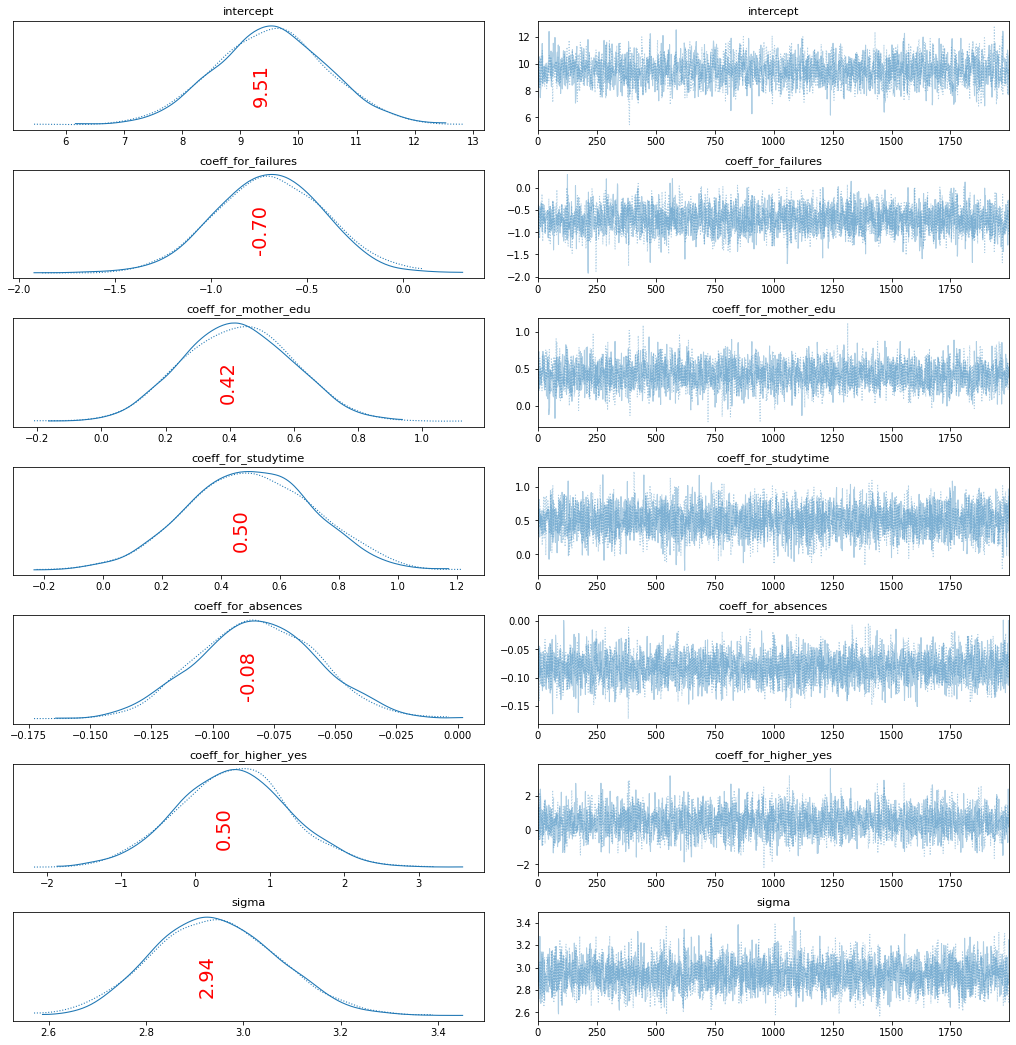

In [22]:
plot_trace(trace);

The left side of the traceplot is the marginal posterior: the values for the variable are on the x-axis with the probability for the variable (as determined by sampling) on the y-axis. The different colored lines indicate that we performed two chains of Markov Chain Monte Carlo. From the left side we can see that there is a range of values for each weight. The right side shows the different sample values drawn as the sampling process runs.

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f885f9034a8>,
      dtype=object)

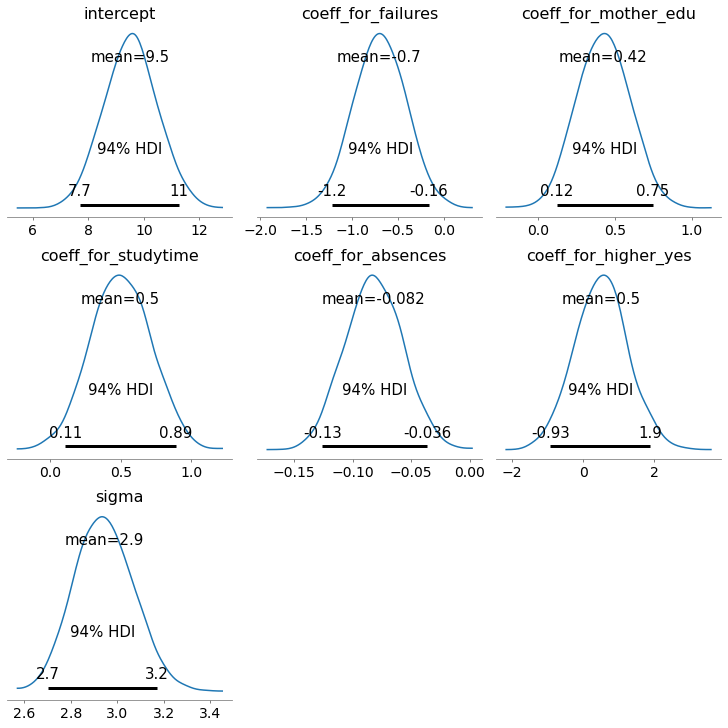

In [23]:
pm.plot_posterior(trace, figsize = (10, 10))

#### Makde prediction: posterior predictive distribution

In linear regression, we only have a single best estimate for model parameters, which ignores uncertainity about model parameters.

In bayesian linear regression, we are able to have the posterior distribution of model parameters $p(w|D$ depends on training data $D=[(x_0,y_0), \dots, (x_n,y_n)]$. Then, we can infer the posterior predictive distribution of the label  $\tilde{y}$ given testing data $\tilde{x}$, which can be calculated by marginalizing the posterior distribution of model parameters and the distribution of $\tilde{y}$ given model parameters.


 
$p(\tilde{y}|\tilde{x},D)=\int p(\tilde{y}|w,\tilde{x},D)p(w|D)dw$ 

MCMC is also used due to the intractable distribution $p(\tilde{y}|w,\tilde{x},D)p(w|D)$

In [24]:
# sample the posterior predictive distribution
with model_build(X_test):
    ppc = pm.sample_posterior_predictive(trace)

100%|██████████| 4000/4000 [00:06<00:00, 572.85it/s]


In [25]:
post_predict = np.array(ppc['y'])
print(post_predict.shape)

(4000, 90)


For each testing data sample, we obtain 4000 estimations instead of a single and fixed guess in LR.

In [26]:
true_test = y_test.Grade.values

In [32]:
# check each sample predictive distribution
def plot_posteriorestimation(estimates, actual):
  plt.figure(figsize(10, 10))
  sns.distplot(estimates, hist = True, kde = True, bins = 19,
                 hist_kws = {'edgecolor': 'k', 'color': 'darkblue'},
                kde_kws = {'linewidth' : 4},
                label = 'Estimated Dist.')
    
  plt.vlines(x = actual, ymin = 0, ymax = 0.15, 
               linestyles = '--', colors = 'red',
               label = 'Observed Grade',
              linewidth = 2.5)
    
  mean_loc = np.mean(estimates)
  plt.vlines(x = mean_loc, ymin = 0, ymax = 0.15, 
               linestyles = '-', colors = 'orange',
               label = 'Mean Estimate',
               linewidth = 2.5)
  plt.vlines(x = np.percentile(estimates, 95), ymin = 0, ymax = 0.08, 
               linestyles = ':', colors = 'blue',
               label = '95% Confidence Level',
               linewidth = 2.5)
  plt.vlines(x = np.percentile(estimates, 5), ymin = 0, ymax = 0.08, 
               linestyles = '-.', colors = 'blue',
               label = '5% Confidence Level',
               linewidth = 2.5)
  plt.legend(loc = 1)
  plt.title('Density Plot for Test Observation');
  plt.xlabel('Grade'); plt.ylabel('Density');
    
  print('True Grade = %d' % actual)
  print('Average Estimate = %0.4f' % mean_loc)
  print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

#### Select two students and check their posterior predictive distribution of their grades. 


This posterior predictive distribution could be regarded as **our beliefs about each student's true long-term average grades** (if the training data is unbiased)


Bob is suspicious because our
beliefs about his true average rating are both narrow and
close to 5, while Alice is less suspicious because our beliefs
about her true average rating are more spread out.

True Grade = 13
Average Estimate = 11.3206
5% Estimate = 6.3956    95% Estimate = 16.1217


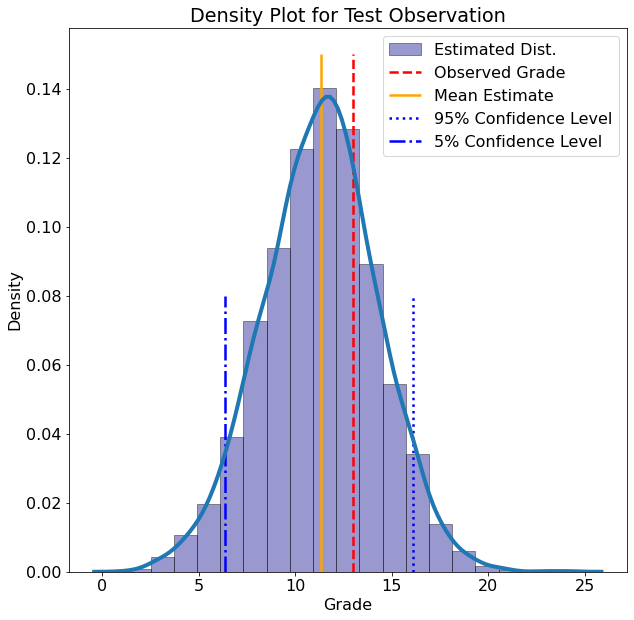

In [33]:
student_id = 20
plot_posteriorestimation(post_predict[:,student_id], true_test[student_id])

True Grade = 18
Average Estimate = 12.6226
5% Estimate = 7.7941    95% Estimate = 17.6002


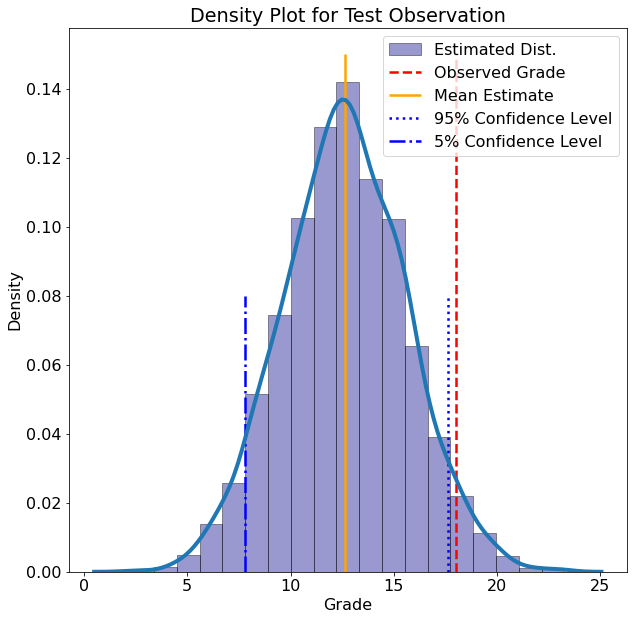

In [34]:
student_id = 70
plot_posteriorestimation(post_predict[:,student_id], true_test[student_id])


Student 70 is suspicious because his observed/true grade is out of the 90% confidence level, while student 20 is less suspicious because his grade is close to the mean value of our predictive distribution. 

#### Evaluate model performances

We can use any statistic of the posterior predictive distributions such as mean or median values as our point estimations that can be used to compare with true values for model evaluation.

In [30]:
# We can use median value to represent the posterior predictive distribution
median_prediction = np.median(post_predict, axis=0)
mae = np.mean(abs(median_prediction - true_test))
rmse = np.sqrt(np.mean((median_prediction - true_test) ** 2))
print('Using Linear Regression, MAE is %0.2f' %  mae)  
print('Using Linear Regression, RMSE is %0.2f' %  rmse) 

Using Linear Regression, MAE is 2.73
Using Linear Regression, RMSE is 3.27
